# Import and Load Data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tqdm
import random

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [ ]:
SEED = 42
def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)

seed_all()

In [ ]:
df = pd.read_csv('drive/MyDrive/CS671_project/data/diabetes_binary_health_indicators_BRFSS2015.csv')

# EDA & Preprocessing

In [ ]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## Dependent variable

In [ ]:
y = df['Diabetes_binary'].astype(int)
y.value_counts(normalize=True)

,proportion
Diabetes_binary,
0,0.860667
1,0.139333


The dataset is imbalanced, with only ~14% of positive class subjects (i.e., those with diabetes). Subsampling or data augmentation will need to be performed to solve the issue.

## Independent variables

There are 21 dependent variables, listed below by their types:
- Continuous: `BMI`, `MenHlth`, `PhysHlth`
- Ordinal: `GenHlth`, `Age`, `Education`, `Income`
- Categorical: `HighBP`, `HighChol`, `CholCheck`, `Smoker`, `Stroke`, `HeartDiseaseorAttack`, `PhysActivity`, `Fruits`, `Veggies`, `HvyAlcoholConsump`, `AnyHealthcare`, `NoDocbcCost`, `DiffWalk`, `Sex`. All categorical variables invovled are binary.

In [ ]:
X = df.iloc[:,1:]
X.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


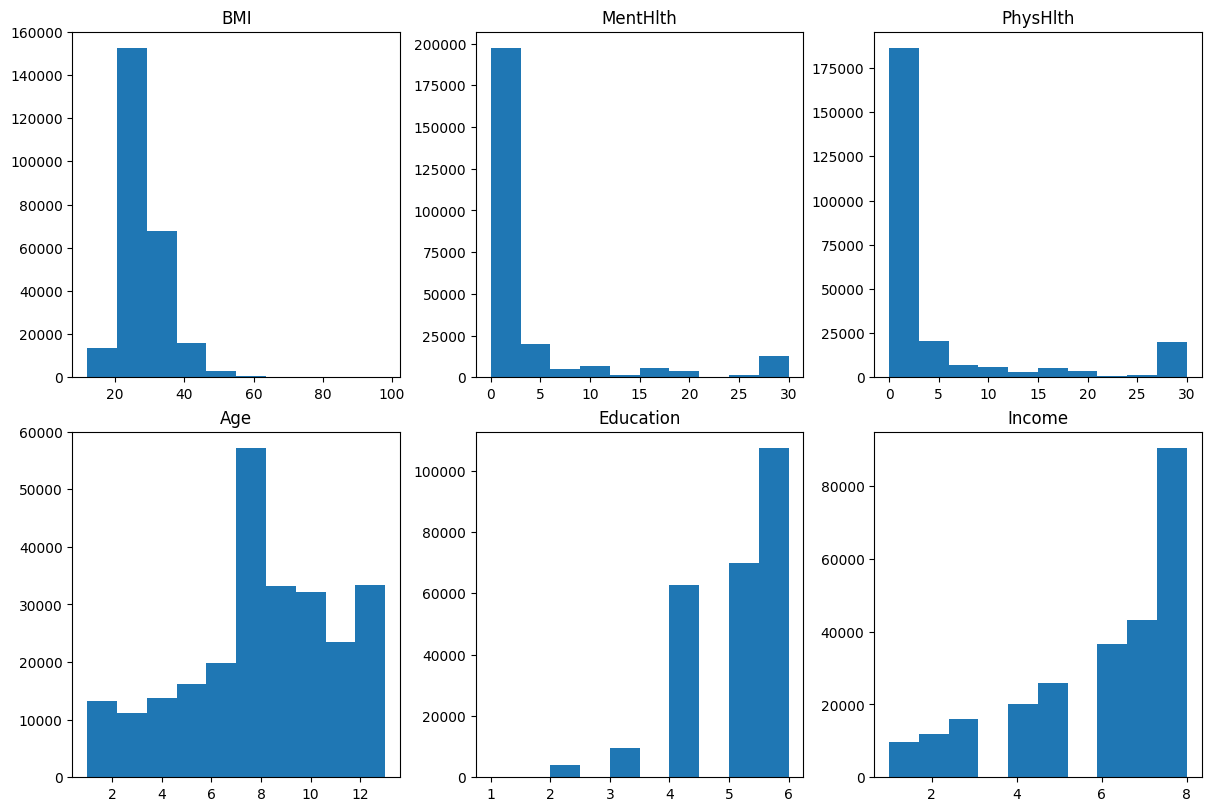

In [ ]:
var_cont = ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
nrow, ncol = 2, 3
fig1, axes = plt.subplots(nrow, ncol, figsize=(12, 8), layout='constrained')

for i in range(len(var_cont)):
  r, c = i // ncol, i % ncol
  axes[r][c].hist(X[var_cont[i]])
  axes[r][c].set_title(var_cont[i])
fig1.show()


## EDA through ROC

We explore the predictive power of each feature using ROC.

Observations:
- One line (`GenHlth`) almost always outperforms any other feature, indicating its role as a potential significant predictor.
- Plenty of variables are no better than random guess, indicating the necessity of more complex models / correlation between variables.

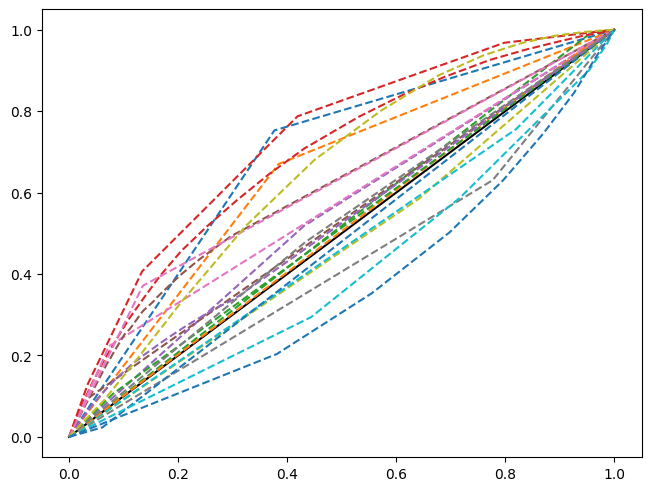

In [ ]:
fig, ax = plt.subplots(layout='constrained')
ax.plot(np.linspace(0,1,2), np.linspace(0,1,2), color='k')
for col in X.columns:
    fpr, tpr, thres = roc_curve(y, X[col])
    # auc = roc_auc_score(y, X[col])
    # if auc < 0.5: # below line
    #   fpr, tpr, thres = roc_curve(y, -X[col])
    # else:
    #   fpr, tpr, thres = roc_curve(y, X[col])
    ax.plot(fpr, tpr, '--')

# Variable Importance

## Data Preparation

In order to solve the data imbalance issue, we subsample the negative samples such that there are exactly 50% of positive and 50% negative samples in the used dataset.

We split the data set to let 90% of data be the trianing and validation set and the rest 10% be the testing set.

In [ ]:
subsample_idx = X[y==0].sample(n=y.sum(), random_state=SEED).index
X = pd.concat([X[y==1], X.loc[subsample_idx,:]])
y = pd.concat([y[y==1], y.loc[subsample_idx]])

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED, stratify=y)

In [ ]:
# Pipeline
def compute_fi(modelclass, parameters):
    # Model pipeline: Preprocessing (scaling by robust statistics) + classifier
    scaler = RobustScaler().fit(X_train_val)
    clf = modelclass()
    ppl = Pipeline([('scaler', scaler), ('clf', clf)])

    # CV
    clf_cv = GridSearchCV(ppl, parameters, scoring='f1', refit='f1')
    clf_cv.fit(X_train_val, y_train_val)
    print(f"Best params: {clf_cv.best_params_}")

    # Fit best model
    ppl = clf_cv.best_estimator_
    ppl.fit(X_train_val, y_train_val)
    y_pred = ppl.predict(X_test)
    print(f"Test F1 score: {f1_score(y_test, y_pred)}")

    # Confusion matrix of best model
    cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    cm.plot()
    plt.title("Confusion matrix")
    plt.show()

    # Compute permutation feature importance
    perm_fi = permutation_importance(
        ppl, X, y, scoring='f1', n_repeats=10, random_state=42, n_jobs=2
    )
    print(f"Permutation FI: {perm_fi['importances_mean']}")
    fig, ax = plt.subplots()
    pd.Series(perm_fi['importances_mean'], index=X.columns).plot.bar(yerr=perm_fi['importances_std'], ax=ax)
    ax.set_title("Feature importances")
    ax.set_ylabel("Mean decrease in F1 score")
    fig.tight_layout()

## Baseline: Random Guess

In [ ]:
random_guess = np.full((10, 4), 0.)
for i in range(10):
    y_shuffled = np.random.permutation(y.to_numpy().copy())
    random_guess[i, 0] = f1_score(y, y_shuffled)
    random_guess[i, 1] = precision_score(y, y_shuffled)
    random_guess[i, 2] = recall_score(y, y_shuffled)
    random_guess[i, 3] = accuracy_score(y, y_shuffled)

rg_mean = np.mean(random_guess, axis=0)

for i, scoring in enumerate(('f1', 'precision', 'recall', 'accuracy')):
    print('Mean {} score: {}'.format(scoring, rg_mean[i]))

Mean f1 score: 0.501063769592033
Mean precision score: 0.501063769592033
Mean recall score: 0.501063769592033
Mean accuracy score: 0.501063769592033


## (a) Logistic Regression


Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Test F1 score: 0.7483425414364641


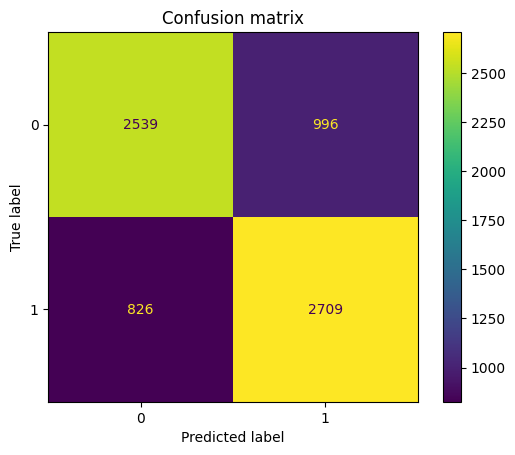

Permutation FI: [ 2.33053859e-02  1.09360640e-02  2.17722774e-03  3.00802345e-02
 -1.31316690e-04  2.53011510e-05  2.84093874e-04 -2.10437708e-04
 -5.79651990e-04 -1.59376952e-04  2.21141134e-03 -1.48642288e-04
  1.10875310e-05  5.26466451e-02  1.31901283e-04  5.84241360e-04
 -6.96764687e-04  1.79218499e-03  2.60833462e-02 -4.86423463e-04
  3.93187817e-04]


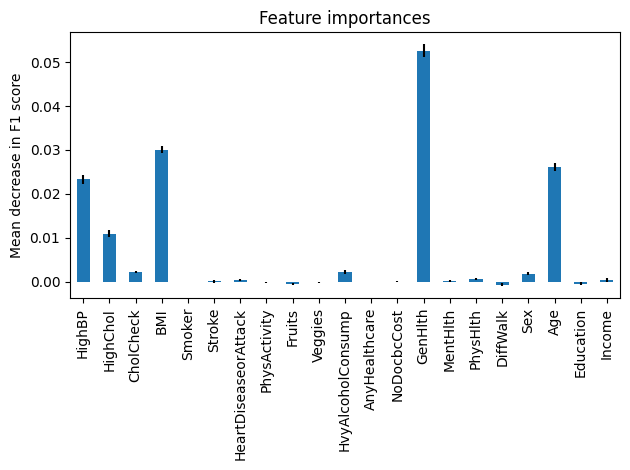

In [ ]:
parameters = {
    "clf__penalty": ('None', 'l1', 'l2'),
    "clf__C": np.logspace(-5, 1, 7),
    "clf__solver": ('lbfgs', 'liblinear')
}
compute_fi(LogisticRegression, parameters)

## (b) Decision Tree

Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 7, 'clf__max_features': 21}
Test F1 score: 0.7565183551692827


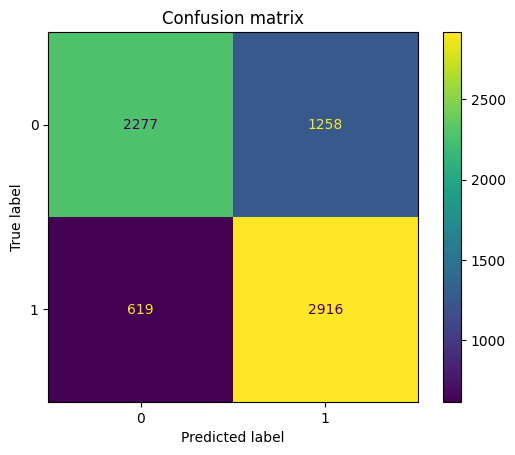

Permutation FI: [0.02724019 0.00533529 0.         0.02620953 0.         0.
 0.00179406 0.         0.         0.         0.00315234 0.
 0.         0.06073812 0.00027867 0.00047633 0.00084869 0.
 0.03204856 0.         0.00076457]


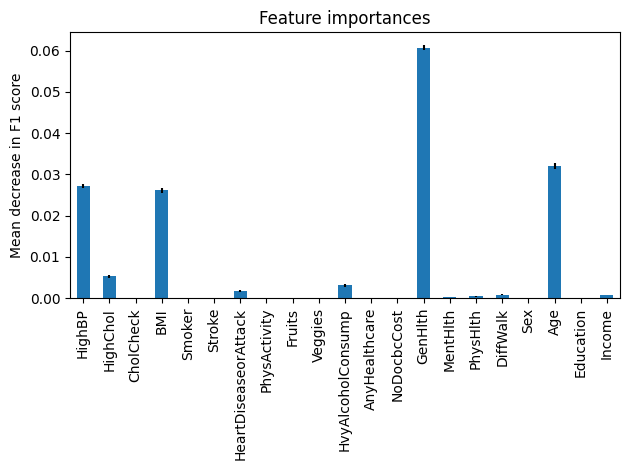

In [ ]:
parameters = {
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_depth": (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
    "clf__max_features": (21, 10, 5, 3)
}
compute_fi(DecisionTreeClassifier, parameters)

## (c) Gradient Boosting

Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__subsample': 1.0}
Test F1 score: 0.7651566070708429


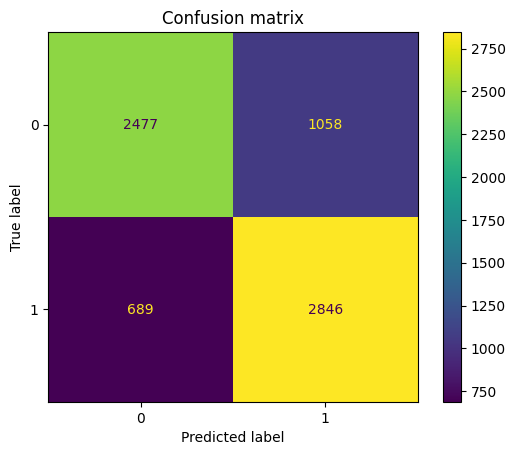

Permutation FI: [ 1.72945754e-02  9.28436682e-03  3.56105512e-03  3.30951042e-02
  4.80490443e-04  2.33740248e-04  1.01654039e-03 -1.64921157e-04
 -8.96488530e-05  9.87100487e-05  4.22734051e-03  2.54565394e-04
  6.22393127e-05  4.37009599e-02  1.99764166e-03  6.98342461e-04
 -4.07556178e-05  2.44618251e-03  2.81127942e-02  4.06881714e-04
  1.94133320e-03]


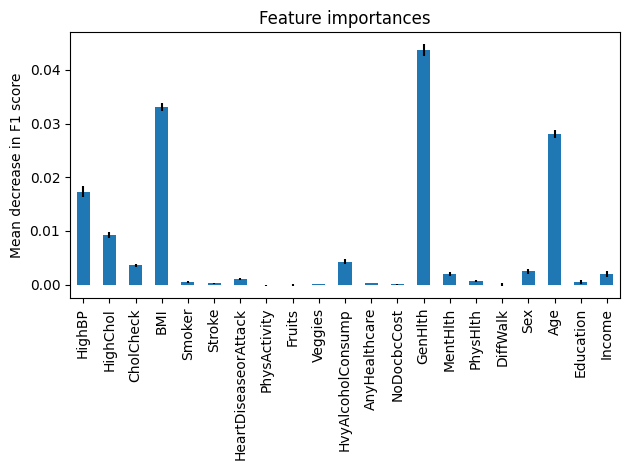

In [ ]:
parameters = {
    "clf__learning_rate": (0.01, 0.1, 1.0),
    "clf__subsample": (0.1, 0.2, 0.5, 1.0),
    "clf__max_depth": (1, 2, 3, 4, 5)
}
compute_fi(GradientBoostingClassifier, parameters)

## (d) Random Forest

Best params: {'clf__criterion': 'gini', 'clf__max_depth': 5}
Test F1 score: 0.7512579899360805


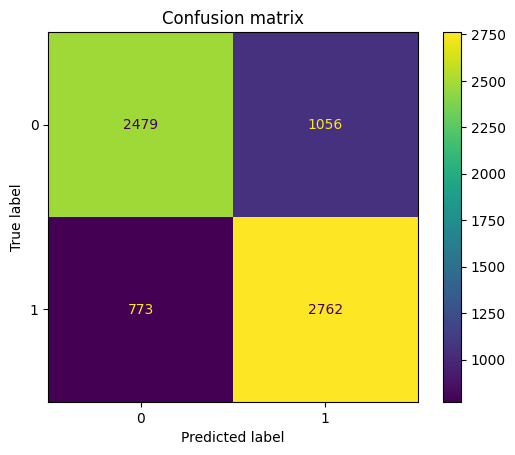

Permutation FI: [ 3.13900938e-02  8.24036736e-03  4.45104412e-04  1.46836587e-02
  4.03985177e-05  9.53920701e-05  1.74505665e-03  5.42866813e-05
  1.49214639e-05 -6.30630622e-05  2.08265831e-04  4.13031222e-05
 -5.06158227e-06  3.39970720e-02  9.55479137e-05 -5.03763366e-04
  2.29282508e-04  1.25213648e-04  9.69523958e-03  1.49695203e-04
  7.06853683e-04]


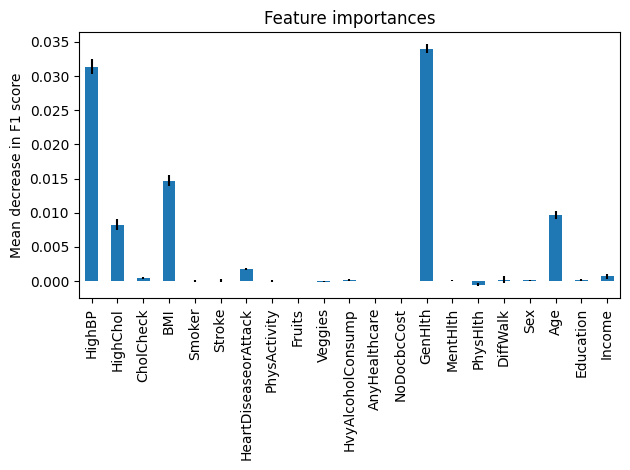

In [ ]:
parameters = {
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_depth": (1, 2, 3, 4, 5)
}
compute_fi(RandomForestClassifier, parameters)

## (e) AdaBoost

Best params: {'clf__algorithm': 'SAMME', 'clf__learning_rate': 0.1}
Test F1 score: 0.7450027012425716


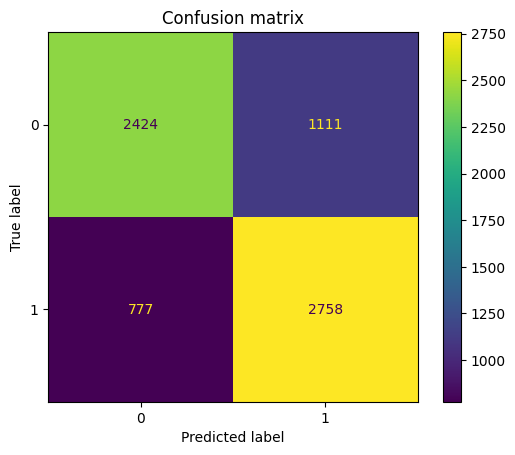

Permutation FI: [ 0.03455089  0.00686854  0.          0.0196646   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.06041588  0.          0.         -0.00011306  0.
  0.01104837  0.          0.        ]


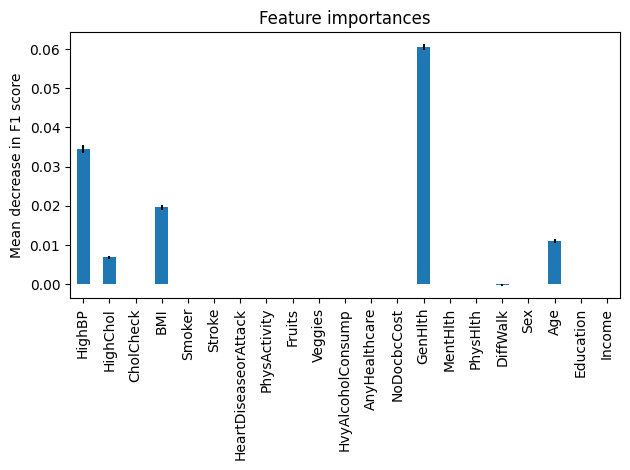

In [ ]:
parameters = {
    "clf__learning_rate": (0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0),
    "clf__algorithm": ('SAMME',)
}
compute_fi(AdaBoostClassifier, parameters)

## (f) XGBoost

Best params: {'clf__grow_policy': 'depthwise', 'clf__learning_rate': 0.1, 'clf__max_depth': 4}
Test F1 score: 0.7661062542030935


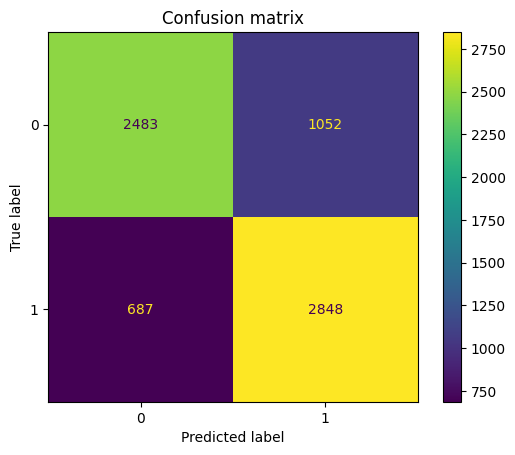

Permutation FI: [ 1.74204724e-02  9.00706987e-03  3.32485326e-03  3.21902592e-02
  3.85214257e-05  2.66062872e-04  1.13395378e-03 -3.60446991e-05
 -7.97123317e-06  1.01056357e-04  4.24900840e-03  1.38067111e-04
  8.47132229e-05  4.38317425e-02  1.63910634e-03  2.49278818e-04
 -1.64291152e-04  2.41581807e-03  2.77203901e-02  3.12786812e-04
  2.18728155e-03]


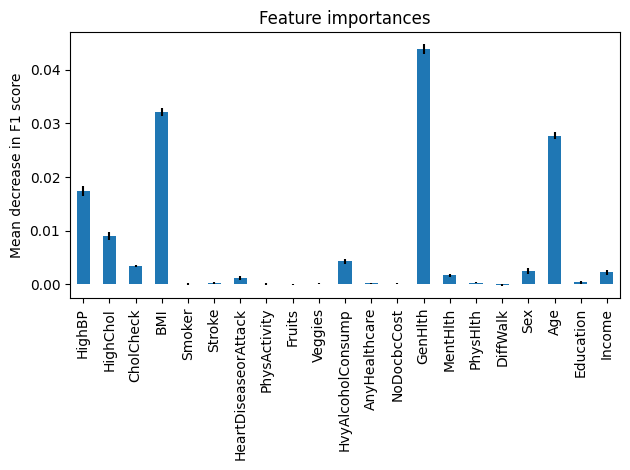

In [ ]:
parameters = {
    "clf__max_depth": (1, 2, 3, 4, 5),
    "clf__learning_rate": (0.1, 1.0, 10.0),
    "clf__grow_policy": ('depthwise', 'lossguide')
}
compute_fi(XGBClassifier, parameters)

# Results & Analysis

Comparing across the six permutation FI graphs, we find that all models suggest that **Genetal Health**, **BMI**, **Age**, **High Blood Pressure**, and **High Cholestrol** are important variables to predicting diabetes. The consistency implies that their importance regardless of the class of model we choose.


# Conclusion

Logistic Regression: 1s

SVC: 3m

DTC: 0s

GBC: 9s

RFC: 13s

ABC: 2s

XGB: 1s